Resources:
https://www.learnpytorch.io/01_pytorch_workflow/

In [1]:
import torch
from torch import nn # nn contains all of PyTorch's building Blocks for Neural network
import matplotlib.pyplot as plt

#check PyTorch version
torch.__version__

'2.0.1+cu118'

### Data Preparing and Loading



We will use a Linear Regression Formula to make a straight line with known **parameters**

In [2]:
# create known parameters
weight = 0.7
bias = 0.3

#create
start = 0
end = 1
step = 0.02
X = torch.arange(start,end,step).unsqueeze(dim=1)
y = weight*X + bias

X[:10],y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [3]:
len(X), len(y)

(50, 50)

### Splitting Data into training and test sets

In [5]:
train_split = int(0.8 *len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

In [6]:
len(X_train), len(X_test)

(40, 10)

Let's visalize the data

In [7]:
def plot_prediction(train_data=X_train,
                    train_labels=y_train,
                    test_data=X_test,
                    test_labels=y_test,
                    predictions=None):
  """
  Plots training data, test data and compare predictions
  """
  plt.figure(figsize=(10,7))

  #plot train data
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  #plot test data
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    plt.scatter(test_data,predictions, c="r", s=4, label="Prediction")

  # show the legend
  plt.legend(prop={"size":14})

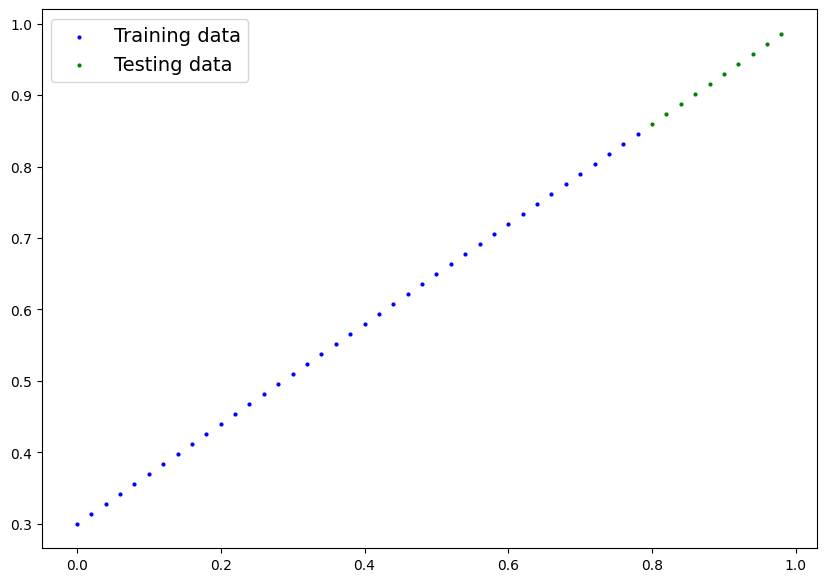

In [9]:
plot_prediction()

### Build Model

In [10]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                   requires_grad=True) # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)


### PyTorch model building essentials

- `torch.nn`	Contains all of the building blocks for computational graphs (essentially a series of computations executed in a particular way).
- `torch.nn.Parameter`	Stores tensors that can be used with nn.Module. If requires_grad=True gradients (used for updating model parameters via gradient descent) are calculated automatically, this is often referred to as "autograd".
- `torch.nn.Module`	The base class for all neural network modules, all the building blocks for neural networks are subclasses. If you're building a neural network in PyTorch, your models should subclass nn.Module. Requires a forward() method be implemented.
- `torch.optim`	Contains various optimization algorithms (these tell the model parameters stored in nn.Parameter how to best change to improve gradient descent and in turn reduce the loss).
- `def forward()`	All nn.Module subclasses require a forward() method, this defines the computation that will take place on the data passed to the particular nn.Module (e.g. the linear regression formula above).

### Checking the contents of a PyTorch model
Now we've got these out of the way, let's create a model instance with the class we've made and check its parameters using `.parameters()` .

In [11]:
torch.manual_seed(42)
model_0 = LinearRegressionModel()

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [12]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [13]:
## making predictions using torch.inference_mode()

with torch.inference_mode():
  y_preds = model_0(X_test)

# Note: in older PyTorch code you might also see torch.no_grad()
# with torch.no_grad():
#   y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [14]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

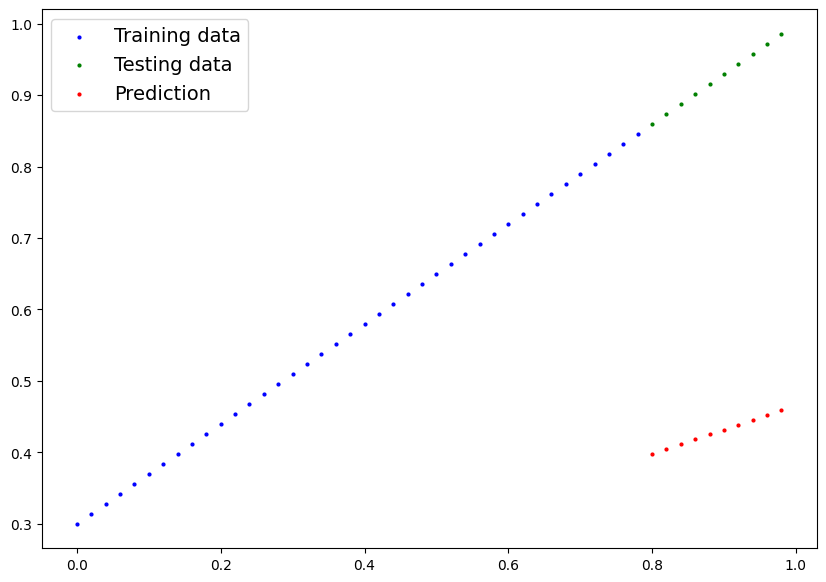

In [15]:
plot_prediction(predictions=y_preds)

### Train a model

Creating a Loss function and Optmizer in PyTorch

In [18]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of target model to optimize
                            lr=0.01) # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))

### Creating an optimization loop in PyTorch

Woohoo! Now we've got a loss function and an optimizer, it's now time to create a training loop (and testing loop).

The training loop involves the model going through the training data and learning the relationships between the features and labels.

The testing loop involves going through the testing data and evaluating how good the patterns are that the model learned on the training data (the model never see's the testing data during training).

Each of these is called a "loop" because we want our model to look (loop through) at each sample in each dataset.

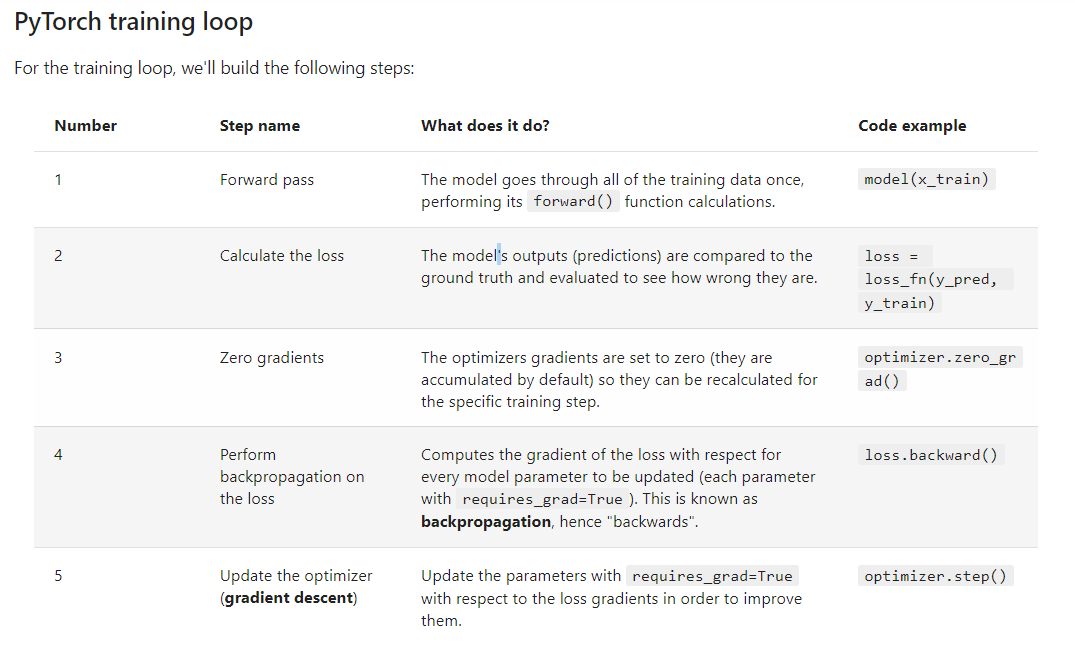

In [22]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 200

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside
    y_pred = model_0(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode():
    # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.024458957836031914 | MAE Test Loss: 0.05646304413676262 
Epoch: 10 | MAE Train Loss: 0.021020207554101944 | MAE Test Loss: 0.04819049686193466 
Epoch: 20 | MAE Train Loss: 0.01758546568453312 | MAE Test Loss: 0.04060482233762741 
Epoch: 30 | MAE Train Loss: 0.014155393466353416 | MAE Test Loss: 0.03233227878808975 
Epoch: 40 | MAE Train Loss: 0.010716589167714119 | MAE Test Loss: 0.024059748277068138 
Epoch: 50 | MAE Train Loss: 0.0072835334576666355 | MAE Test Loss: 0.016474086791276932 
Epoch: 60 | MAE Train Loss: 0.0038517764769494534 | MAE Test Loss: 0.008201557211577892 
Epoch: 70 | MAE Train Loss: 0.008932482451200485 | MAE Test Loss: 0.005023092031478882 
Epoch: 80 | MAE Train Loss: 0.008932482451200485 | MAE Test Loss: 0.005023092031478882 
Epoch: 90 | MAE Train Loss: 0.008932482451200485 | MAE Test Loss: 0.005023092031478882 
Epoch: 100 | MAE Train Loss: 0.008932482451200485 | MAE Test Loss: 0.005023092031478882 
Epoch: 110 | MAE Train Loss: 0.0089

In [26]:
with torch.inference_mode():
      y_pred = model_0(X_test)

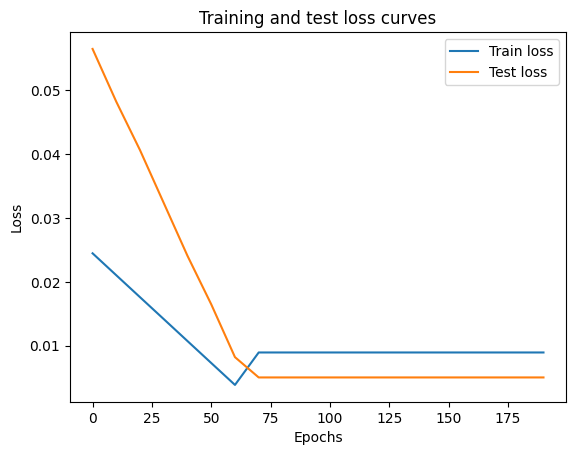

In [23]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

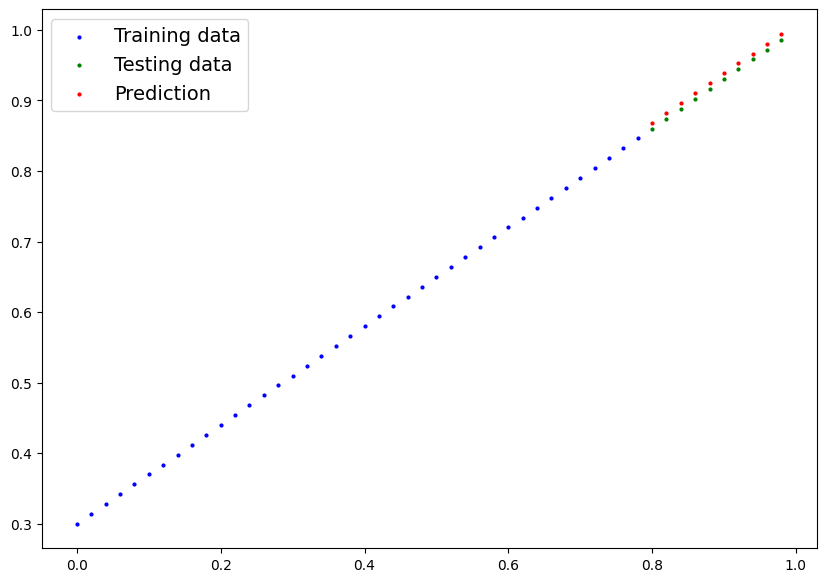

In [27]:
plot_prediction(predictions = y_pred)

In [24]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


### Making predictions with a trained PyTorch model (inference)
Once you've trained a model, you'll likely want to make predictions with it.

We've already seen a glimpse of this in the training and testing code above, the steps to do it outside of the training/testing loop are similar.

There are three things to remember when making predictions (also called performing inference) with a PyTorch model:

1. Set the model in evaluation mode (model.eval()).
2. Make the predictions using the inference mode context manager (with torch.inference_mode(): ...).
3. All predictions should be made with objects on the same device (e.g. data and model on GPU only or data and model on CPU only).

The first two items make sure all helpful calculations and settings PyTorch uses behind the scenes during training but aren't necessary for inference are turned off (this results in faster computation). And the third ensures that you won't run into cross-device errors.

### Saving and loading a PyTorch model

For saving and loading models in PyTorch, there are three main methods you should be aware of.

- `torch.save`	Saves a serialized object to disk using Python's pickle utility. Models, tensors and various other Python objects like dictionaries can be saved using torch.save.
- `torch.load`	Uses pickle's unpickling features to deserialize and load pickled Python object files (like models, tensors or dictionaries) into memory. You can also set which device to load the object to (CPU, GPU etc).
- `torch.nn.Module.load_state_dict`	Loads a model's parameter dictionary (model.state_dict()) using a saved state_dict() object.

In [28]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [30]:
# saving our PyTorch model params
from pathlib import Path

#1. Create model directory
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#2. Create model save path
MODEL_NAME = "01_pytorch_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)



In [31]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1107 Oct  5 16:26 01_pytorch_model_0.pth


### Loading the model
Let's test it out by created another instance of LinearRegressionModel(), which is a subclass of torch.nn.Module and will hence have the in-built method load_state_dict().

In [32]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>


Excellent! It looks like things matched up.

Now to test our loaded model, let's perform inference with it (make predictions) on the test data.

In [33]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [34]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test) # perform a forward pass on the test data with the loaded model


Now we've made some predictions with the loaded model, let's see if they're the same as the previous predictions.

In [36]:
# Compare previous model predictions with loaded model predictions (these should be the same)
y_pred == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])